In [39]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
from scipy.stats import lognorm, chi2, norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH

In [116]:
dfile = os.path.join(DATA_PATH, 'eorsky_3.00hours_Nside128_sigma0.03_fwhm12.13_uv.uvh5')
# dfile = os.path.join(DATA_PATH, 'FlatSpecEoR_Jy_SEED001.uvh5')
# dfile = os.path.join(DATA_PATH, 'zen.2458116.34176.xx.HH.uvOCRS')
uvd = UVData()
uvd.read(dfile)
print(uvd.get_antpairs())
print(uvd.Nbls,uvd.Nfreqs, uvd.Nspws, uvd.Ntimes)
# print(dir(uvd)) 

[(0, 11), (0, 12), (11, 12)]
3 384 1 982


In [117]:
cosmo = hp.conversions.Cosmo_Conversions()
print(cosmo)

Cosmo_Conversions object at <0x1c254bae48>
Om_L : 0.6844; Om_b : 0.0491; Om_c : 0.2644; Om_M : 0.3135; Om_k : 0.0021; H0 : 67.2700


In [118]:
# the beamfile (eorsky)
beam_freqs = uvd.freq_array # in Hz
uvb = hp.PSpecBeamGauss(fwhm=0.21170844, beam_freqs=beam_freqs[0])
# print(uvb.power_beam_int())
# print(uvb.power_beam_sq_int())

# # List of beamfile to load. This is a healpix map.
# beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')

# # intantiate beam and pass cosmology, if not fed, a default Planck cosmology will be assumed
# uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)
# # print(uvb.get_Omegas(('xx', 'xx')))

In [121]:
# Converting units
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='pI')
uvd.data_array *= Jy_to_mK[None, None, :, None]

In [122]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)         #even
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)          #odd

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

In [123]:
ds.rephase_to_dset(0)

In [124]:
# change units of UVData objects
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

In [127]:
# Specify which baselines to include
baselines = [(0, 11), (0, 12), (11, 12)]

In [167]:
# Define uvp
# Polarization pairs for this specific simulation data is 'pI'
# spw_range length = number of delays
uvp = ds.pspec(baselines, baselines, (0, 1), [('pI', 'pI')], spw_ranges=[(300, 384)],  
               input_data_weight='identity',
               norm='I', taper='blackman-harris', verbose=True)


Setting spectral range: (300, 384)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((0, 11), (0, 11))
pol: (1, 1)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 12), (0, 12))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((11, 12), (11, 12))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


In [168]:
# return the nearest delay mode
def get_dly(dly, key):
    dlys = uvp.get_dlys(key[0]) * 1e9
    dlys = np.asarray(dlys)
    idx = (np.abs(dlys - dly)).argmin()
    return (dlys[idx], idx)

In [258]:
spw = 0
blp = (0, 11), (0, 11)
pol = ('pI', 'pI')
key = (spw, blp, pol)
dlys = uvp.get_dlys(spw) * 1e9
power = np.abs(np.real(uvp.get_data(key)))

time = [0, 150]
time = []
for i in range(0, 300, 20):
    time.append([0+i, 150+i])
dly = [-89000, 89000]

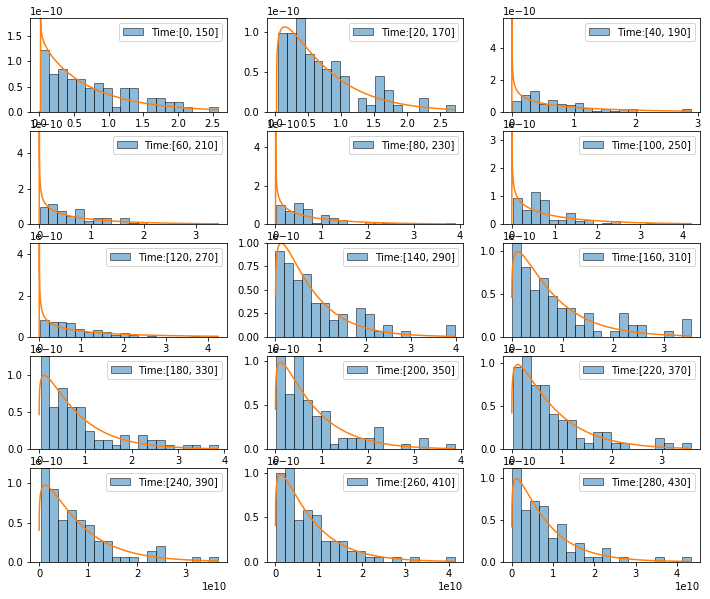

In [288]:
# get power values at time[] for dly[]
popt = [] 
x = []

for i in range(len(time)):
    data1 = power[time[i][0]:(time[i][0]+1)][:,get_dly(dly[0], key)[1]:get_dly(dly[1], key)[1]]
    data2 = power[time[i][0]:(time[i][0]+1)][:,get_dly(dly[0], key)[1]:get_dly(dly[1], key)[1]]
    data = [data1[0], data2[0]]

    # data = power[time[0]:time[1]][:,get_dly(dly[0], key)[1]:get_dly(dly[1], key)[1]]

    # sum up power values at each delay mode for all time
    data = np.transpose(data)
    b = []
    for j in range(len(data)):
        a = data[j][0]
        for k in range(len(data[j])-1):
            a += data[j][k]
        b.append(a)
    x.append(b)
    popt.append(chi2.fit(x, 3, loc=np.mean(x), scale=np.std(x)))
    
plt.figure(figsize=(12,10))
for i in range(1, len(time)+1):
    plt.subplot(5, 3, i)
    i -= 1
    plt.hist(x[i], alpha=0.5, bins=20, density=True, linewidth=1, edgecolor='k', label='Time:'+str(time[i]))
    fit_x = np.linspace(0, np.sort(x[i])[-1], 1000)
    plt.plot(fit_x, chi2.pdf(fit_x, popt[i][0], loc=popt[i][1], scale=popt[i][2])) 
    plt.legend()